# 1. Installs and imports setup

In [ ]:
# First, install correct versions (run this once)
!pip install --upgrade scikit-learn==1.3.0 imbalanced-learn
# then restart

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
train.info()

# 2. EDA

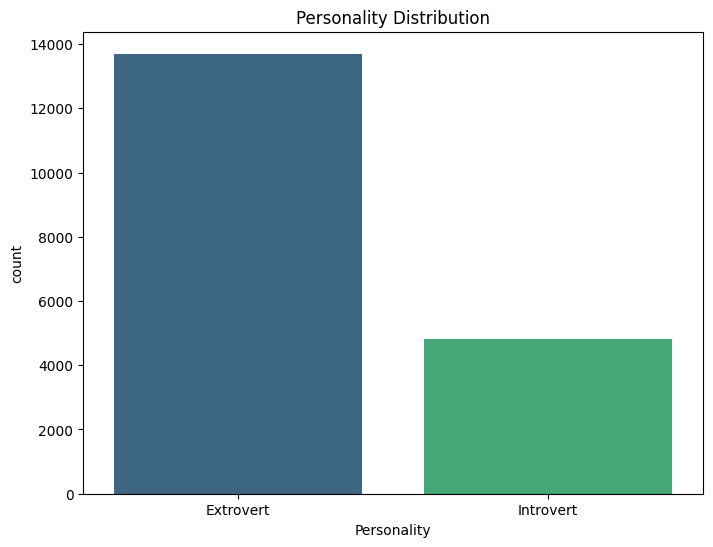

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Personality', data=train, palette='viridis')
plt.title('Personality Distribution')
plt.show()

## Numerical Features Analysis

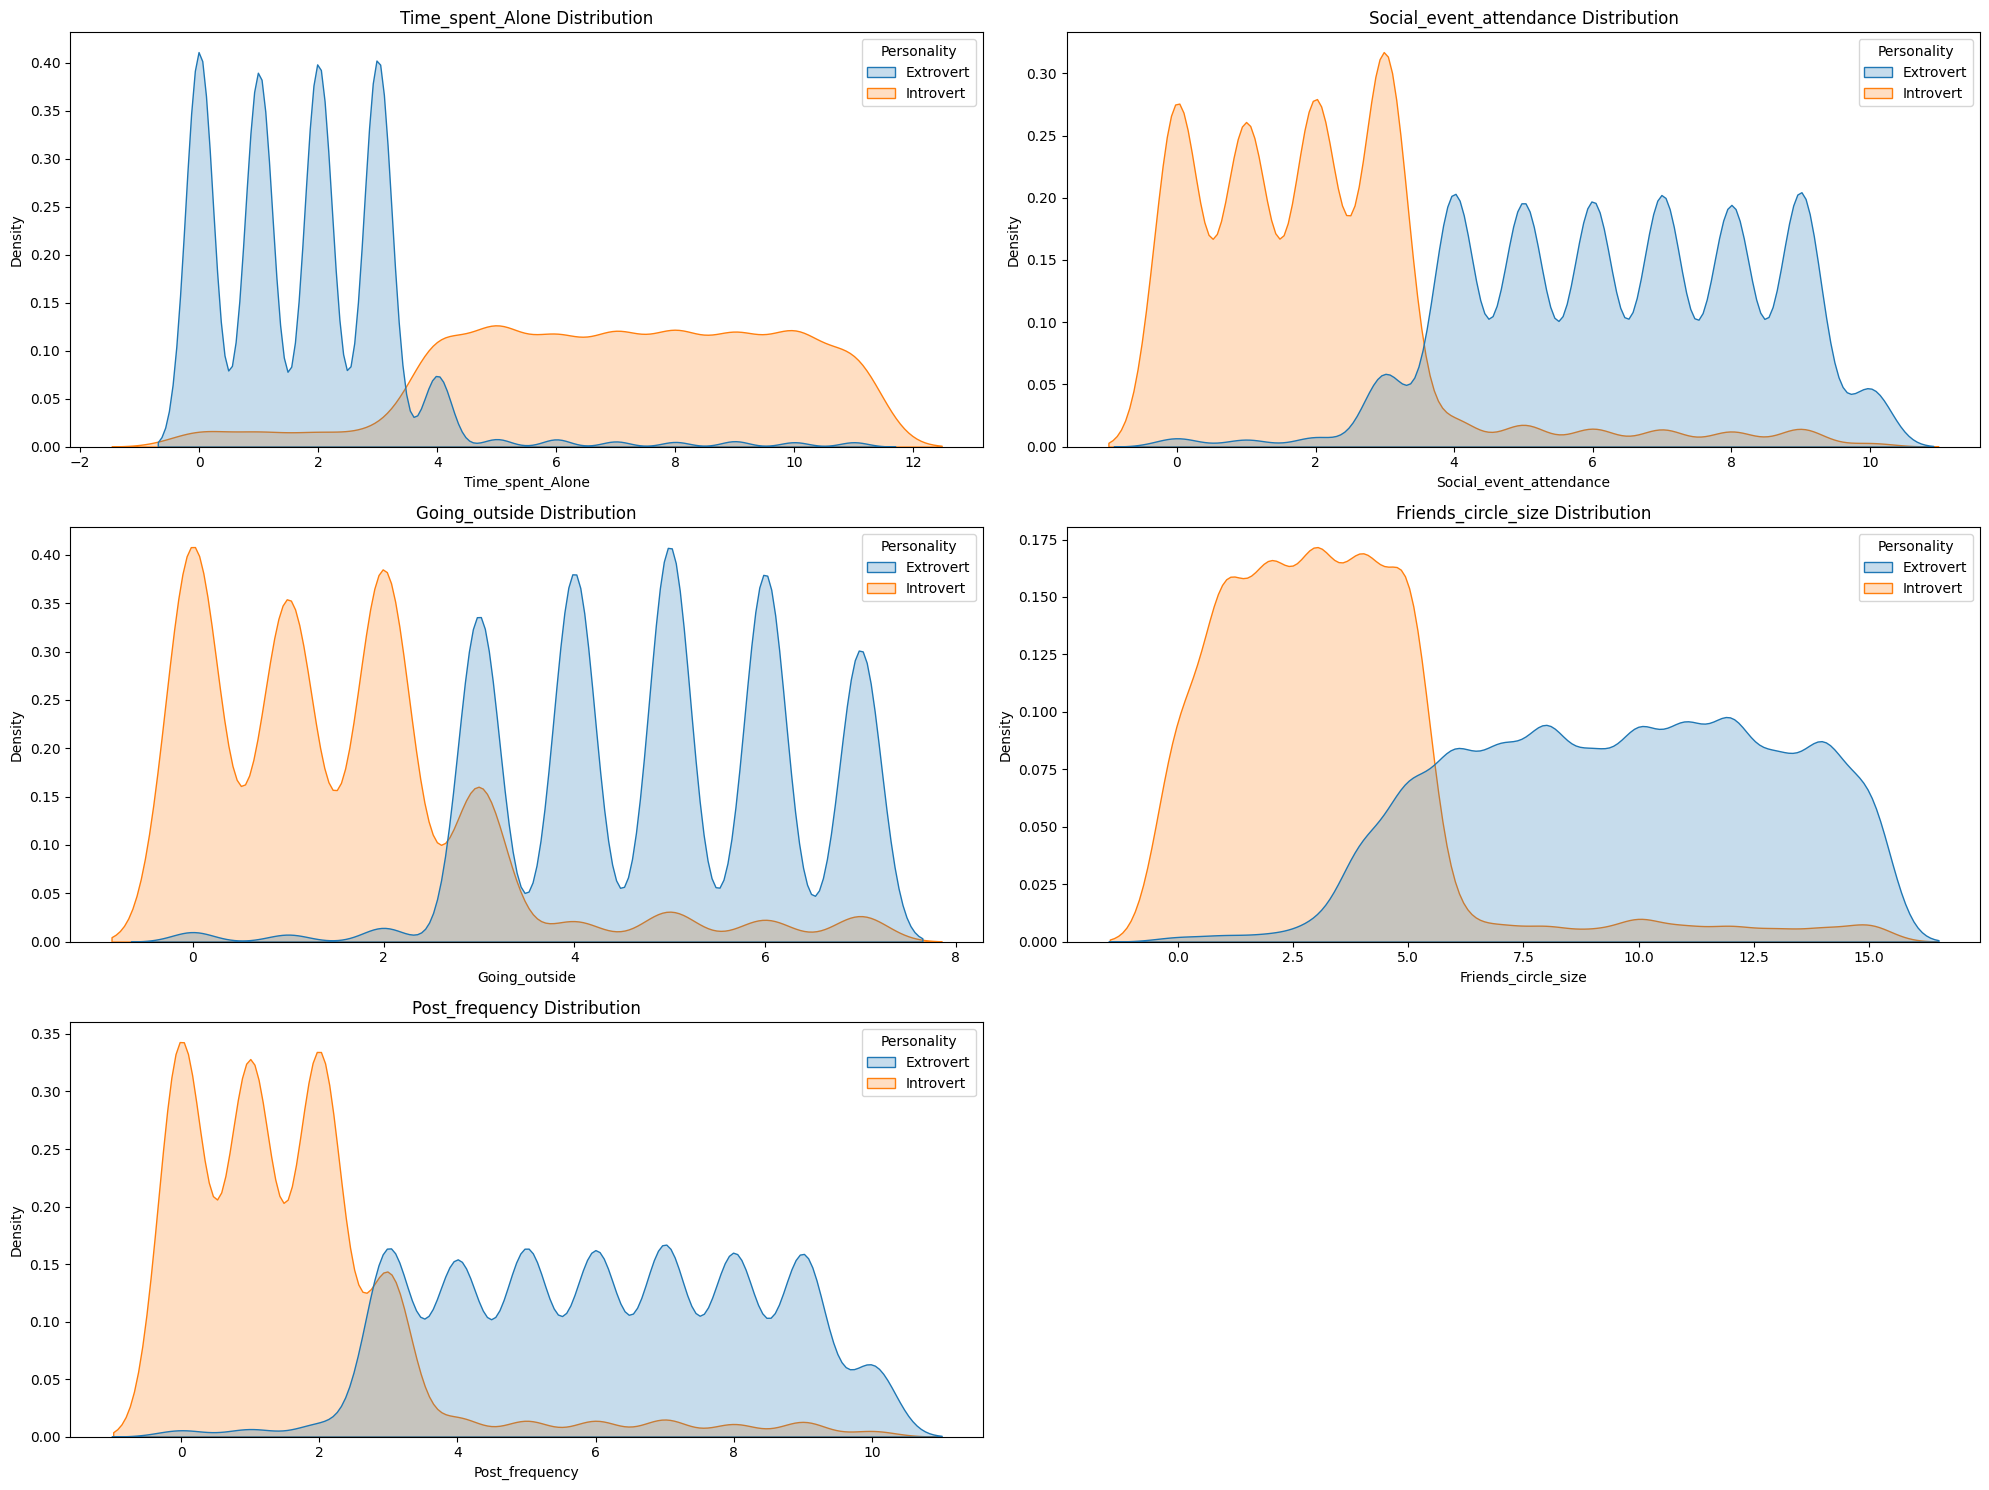

In [5]:
num_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
plt.figure(figsize=(20, 15))
for i, feature in enumerate(num_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=train, x=feature, hue='Personality', fill=True, common_norm=False)
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()

## Categorical Features Analysis

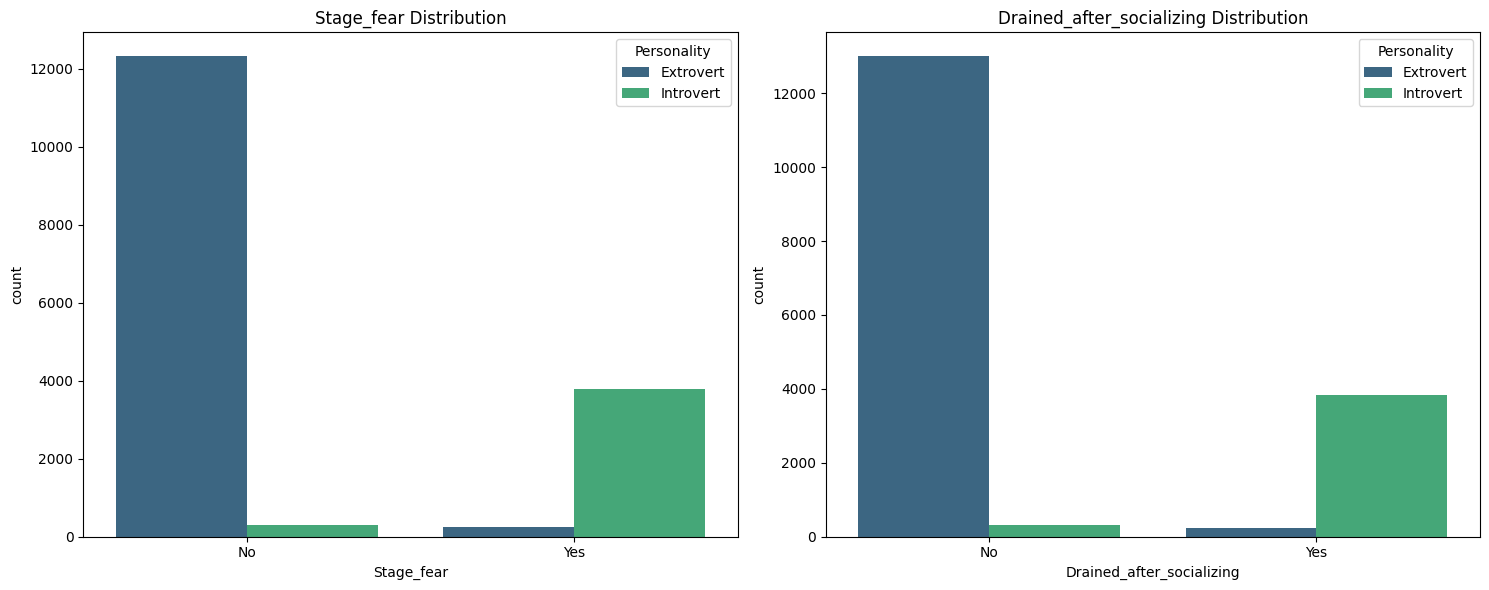

In [6]:
cat_features = ['Stage_fear', 'Drained_after_socializing']
plt.figure(figsize=(15, 6))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(1, 2, i)
    sns.countplot(data=train, x=feature, hue='Personality', palette='viridis')
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()

## Correlation Matrix

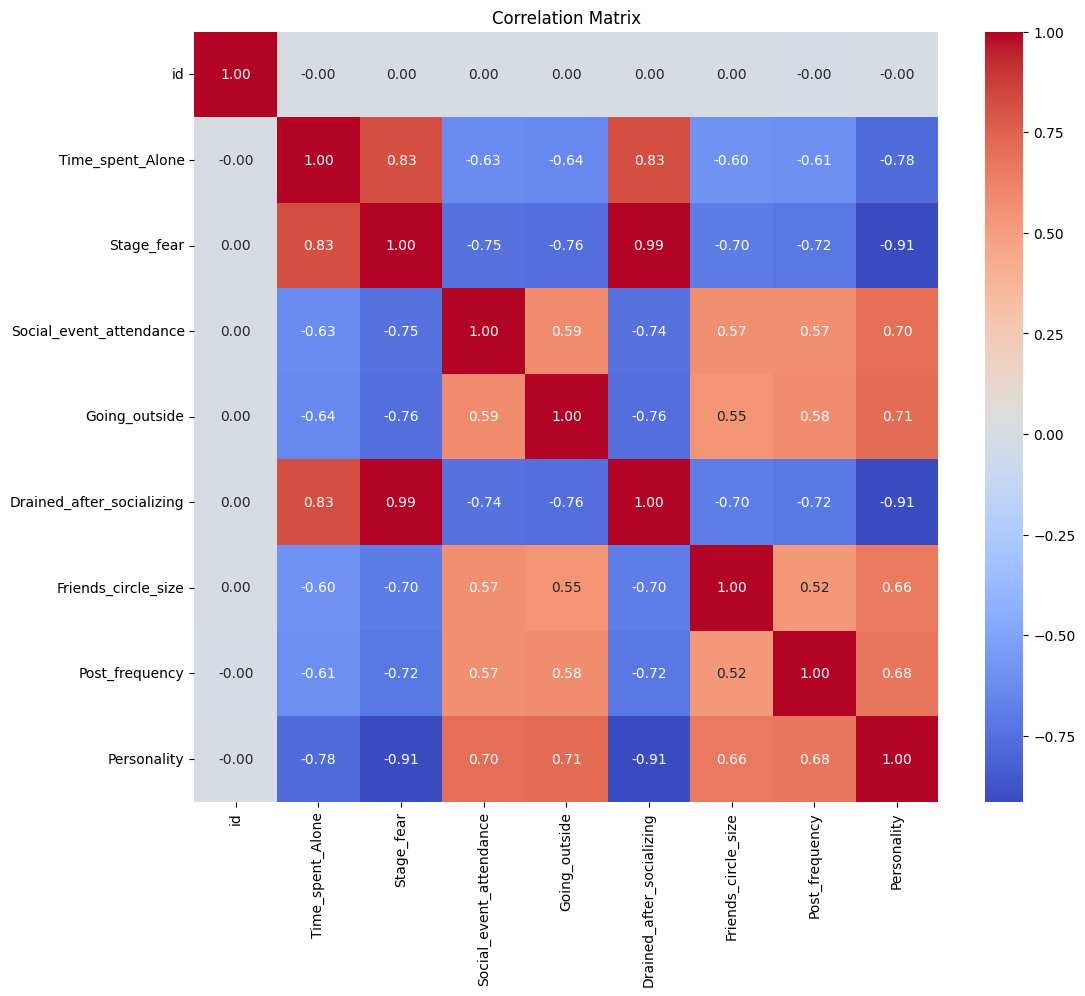

In [7]:
train_corr = train.copy()
train_corr['Stage_fear'] = train_corr['Stage_fear'].map({'Yes': 1, 'No': 0})
train_corr['Drained_after_socializing'] = train_corr['Drained_after_socializing'].map({'Yes': 1, 'No': 0})
train_corr['Personality'] = train_corr['Personality'].map({'Introvert': 0, 'Extrovert': 1})

corr = train_corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 3. Feature Engineering

In [8]:
def create_features(df):
    df = df.copy()
    df['Social_Interaction_Ratio'] = df['Social_event_attendance'] / (df['Time_spent_Alone'] + 1e-5)
    df['Energy_Balance'] = df['Drained_after_socializing'].map({'Yes': -1, 'No': 1}) * df['Social_event_attendance']
    df['Social_Activity_Index'] = df['Social_event_attendance'] + df['Going_outside'] + df['Friends_circle_size'] / 10
    df['Post_Frequency_Adjusted'] = df['Post_frequency'] / (df['Friends_circle_size'] + 1)
    return df

train_fe = create_features(train)
test_fe = create_features(test)

# 4. Data Preprocessing

In [9]:
def handle_missing(df):
    df = df.copy()
    num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
    cat_cols = ['Stage_fear', 'Drained_after_socializing']
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

train_clean = handle_missing(train_fe)
test_clean = handle_missing(test_fe)

# 5. Handling Class Imbalance

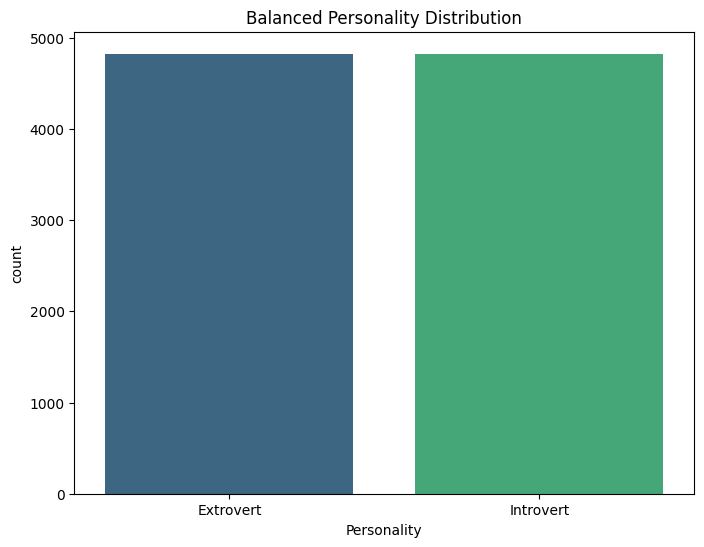

In [10]:
X = train_clean.drop(['id', 'Personality'], axis=1)
y = train_clean['Personality']

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

plt.figure(figsize=(8, 6))
sns.countplot(x=y_res, palette='viridis')
plt.title('Balanced Personality Distribution')
plt.show()

In [12]:
from sklearn.impute import SimpleImputer

# Define preprocessing with imputation
categorical_features = ['Stage_fear', 'Drained_after_socializing']
numerical_features = [col for col in X_res.columns if col not in categorical_features]

# Create separate imputers for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),  # Impute missing numerical values
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

## Updated pipeline with imputation


In [13]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectKBest(score_func=f_classif, k=10)),
    ('classifier', SVC(probability=True, random_state=42))
])

# Same parameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'feature_selector__k': [8, 10, 12]
}

# Verify no NaN values before fitting
print("NaN values in X_res:", X_res.isna().sum().sum())

NaN values in X_res: 6165


# 6. Model Training (SVM with GridSearchCV)

In [14]:
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    scoring='accuracy', 
    cv=5, 
    n_jobs=-1, 
    verbose=1,
    error_score='raise'  # This will show the exact error if any
)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'classifier__C': 10, 'classifier__kernel': 'rbf', 'feature_selector__k': 10}
Best CV accuracy: 0.9589


## Fit GridSearchCV on all resampled data

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Cross-validated results:
              precision    recall  f1-score   support

   Extrovert       0.94      0.98      0.96      4825
   Introvert       0.98      0.94      0.96      4825

    accuracy                           0.96      9650
   macro avg       0.96      0.96      0.96      9650
weighted avg       0.96      0.96      0.96      9650



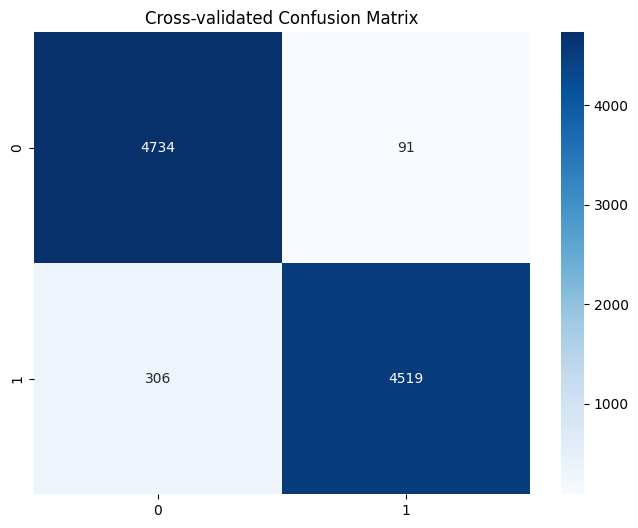

In [16]:
grid_search.fit(X_res, y_res)

# Cross-validated evaluation
from sklearn.model_selection import cross_val_predict

y_pred_cv = cross_val_predict(
    grid_search.best_estimator_, 
    X_res, 
    y_res, 
    cv=5
)

print("Cross-validated results:")
print(classification_report(y_res, y_pred_cv))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_res, y_pred_cv), annot=True, fmt='d', cmap='Blues')
plt.title('Cross-validated Confusion Matrix')
plt.show()

# 8. Submission

In [17]:
test_final = test_clean.drop('id', axis=1)
test_preds = best_model.predict(test_final)

submission = pd.DataFrame({'id': test['id'], 'Personality': test_preds})
submission.to_csv('submission.csv', index=False)
print(submission.head())

      id Personality
0  18524   Extrovert
1  18525   Introvert
2  18526   Extrovert
3  18527   Extrovert
4  18528   Introvert
